In [1]:
#setup
import numpy as np
import random
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.decomposition import PCA

from KNN import KNN

## Zadanie 5. (2 punkty)
Zamiast proponowanej prostej metody rozpoznawania twarzy użyj klasyfikatora KNN. Porównaj skuteczność klasyfikacji dla różnych k, dla danych oryginalnych i danych zredukowanych (dla różnej liczby wymiarów). Porównanie zrób metodą cross-validation dla połączonych obu zestawów danych.

In [2]:
train_x = pd.read_csv('data/ri_train.csv', header=None).T.astype(np.uint8).values
test_x = pd.read_csv('data/ri_test.csv', header=None).T.astype(np.uint8).values
train_y = np.arange(len(train_x)) // 5
test_y = np.arange(len(test_x)) // 2

In [3]:
x = np.vstack((train_x, test_x))
y = np.append(train_y, test_y)

In [4]:
perm = np.random.permutation(len(x))
x = x[perm, :]
y = y[perm]

In [8]:
df = pd.DataFrame({'no_attrs': [], 'k': [], 'mean_score': []})
ks = np.arange(1, 20, 2)
no_attrs = [16, 32, 64, 128, 256]
splits = 35

elems_in_split = len(x) // splits

for attr in tqdm(no_attrs):
    pca = PCA(attr)
    
    score = {k: 0 for k in ks}
    for j in range(splits):
        train_x = np.vstack((x[:j * elems_in_split], x[(j+1) * elems_in_split:]))
        train_y = np.append(y[:j * elems_in_split], y[(j+1) * elems_in_split:])
        test_x = x[j * elems_in_split : (j+1) * elems_in_split]
        test_y = y[j * elems_in_split : (j+1) * elems_in_split]
        
        train_x_proj = pca.fit_transform(train_x)
        test_x_proj = pca.transform(test_x)
        
        knn = KNN(train_x_proj, train_y, test_x_proj, ks)
        for k in ks:
            score[k] += np.count_nonzero(knn[k] == test_y) / len(test_y)
    for k in ks:
        df.loc[len(df)] = [attr, k, score[k]/splits]

score = {k: 0 for k in ks}
for j in range(splits):
    train_x = np.vstack((x[:j * elems_in_split], x[(j+1) * elems_in_split:]))
    train_y = np.append(y[:j * elems_in_split], y[(j+1) * elems_in_split:])
    test_x = x[j * elems_in_split : (j+1) * elems_in_split]
    test_y = y[j * elems_in_split : (j+1) * elems_in_split]

    knn = KNN(train_x, train_y, test_x, ks)
    for k in ks:
        score[k] += np.count_nonzero(knn[k] == test_y) / len(test_y)
for k in ks:
    df.loc[len(df)] = [x.shape[1], k, score[k]/splits]

100%|██████████| 5/5 [00:31<00:00,  6.37s/it]


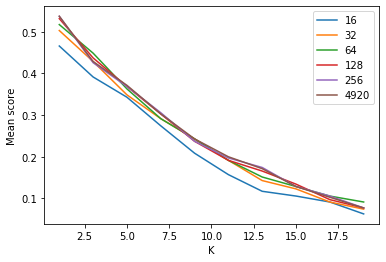

In [9]:
plt.xlabel('K')
plt.ylabel('Mean score')
for attr in no_attrs + [x.shape[1]]:
    data = df[df['no_attrs'] == attr]
    plt.plot(data['k'], data['mean_score'], label=attr)
plt.legend()